In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import pymc.sampling_jax
import scipy.stats as stats
import seaborn as sns
import arviz as az
from scipy.stats import gaussian_kde
import networkx as nx
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# pip install git+https://github.com/pymc-devs/pymc-experimental.git

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300

In [7]:
from packaging import version

# Import additional libraries that are not dependencies of PyMC
import pymc_experimental as pmx

# Check we have the necessary versions to get the new experimental functionality.
assert version.parse(pm.__version__) >= version.parse("5.5.0")
assert version.parse(pmx.__version__) >= version.parse("0.0.7")

# import the new functionality
from pymc_experimental.model_transform.conditioning import do, observe

## Valutazione dell'Efficacia della Terapia Cognitivo-Comportamentale (TCC) nella Riduzione dell'Ansia

#### Contesto:
Psicologi clinici sono interessati a valutare l'efficacia della Terapia Cognitivo-Comportamentale (TCC) nella riduzione dei sintomi di ansia nei pazienti. La TCC è una forma comune di psicoterapia che mira a cambiare schemi negativi di pensiero o comportamento.

#### Obiettivo:
L'obiettivo principale è quantificare quanto sia efficace la TCC nel ridurre i livelli di ansia, misurati attraverso scale di ansia standardizzate.

#### Metodo:
Gli psicologi pianificano di misurare i livelli di ansia prima e dopo un determinato periodo di trattamento con TCC, utilizzando una scala di ansia ben consolidata. Potrebbero considerare l'uso di metodi bayesiani o di apprendimento automatico per tenere conto di variabili confondenti come età, sesso o uso di farmaci.

#### Complicazione:
Senza che gli psicologi lo sappiano, alcuni dei pazienti che partecipano allo studio sono anche iscritti a un programma separato di meditazione mindfulness finalizzato alla riduzione dell'ansia. Questi pazienti praticano tecniche di mindfulness in aggiunta alla ricezione della TCC. Inoltre, questi pazienti tendono a praticare la mindfulness con maggiore diligenza nei giorni in cui hanno sessioni di TCC, credendo che le due terapie si complementino a vicenda nella riduzione dell'ansia.

#### La Sfida:
Proprio come nel tuo esempio di marketing originale, questo crea una variabile confondente. La riduzione dell'ansia potrebbe essere dovuta all'effetto combinato della TCC e della meditazione mindfulness, e non della TCC da sola. Un semplice confronto prima e dopo dei livelli di ansia nel gruppo TCC potrebbe quindi portare a una sovrastima dell'efficacia della TCC nella riduzione dell'ansia.

Per valutare accuratamente l'impatto della sola TCC, gli psicologi avrebbero bisogno di controllare l'influenza del programma di meditazione mindfulness. Ciò potrebbe comportare la progettazione di disegni sperimentali complessi o l'uso di metodi statistici per isolare i contributi individuali di ciascun approccio terapeutico.



/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


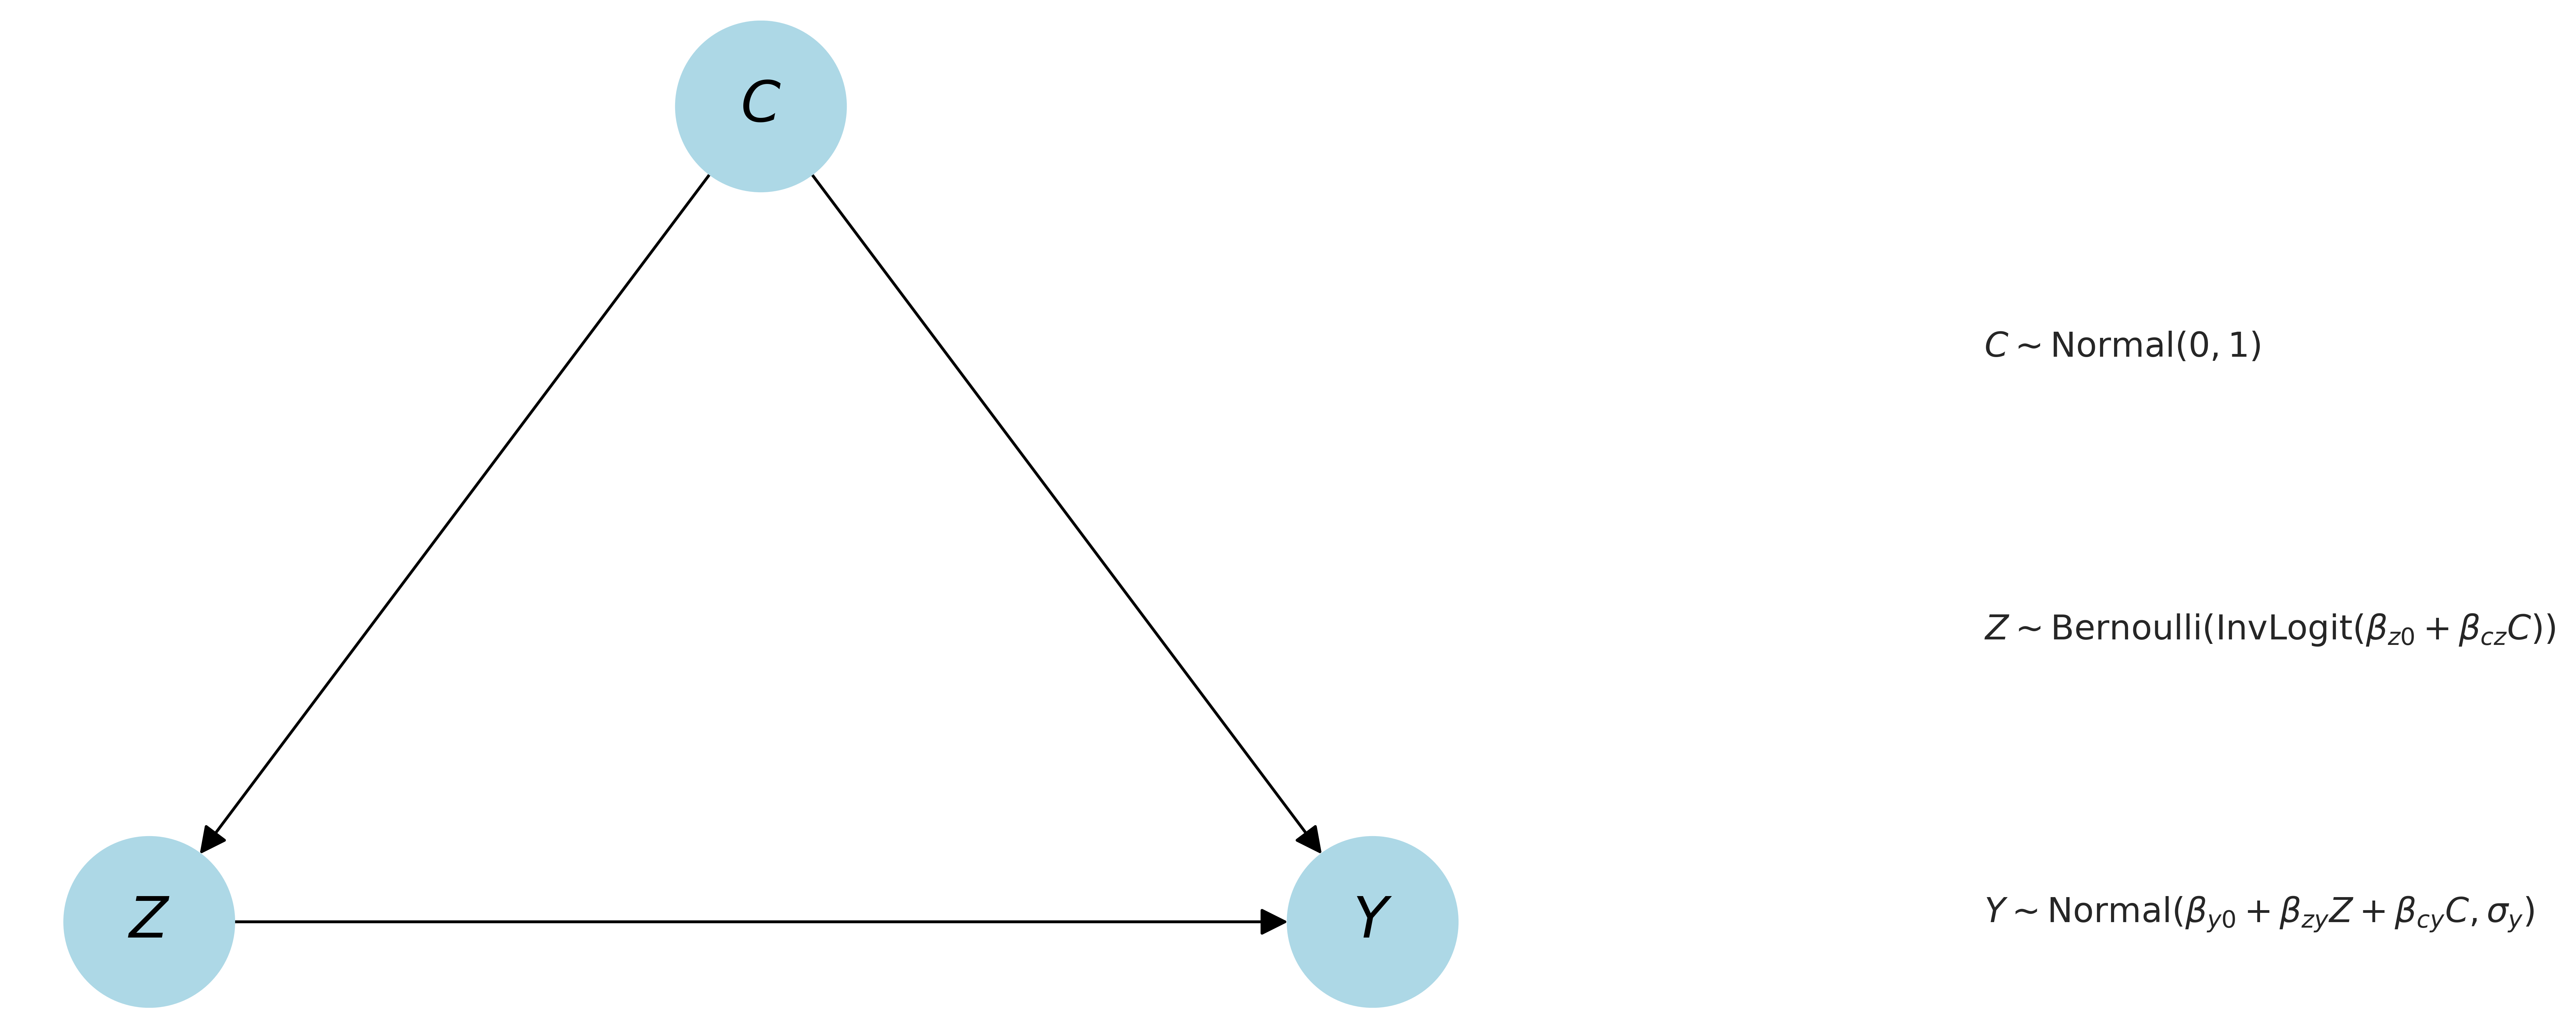

In [8]:
# Initialize a directed graph
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(["Y", "Z", "C"])

# Add edges
G.add_edges_from([("Z", "Y"), ("C", "Y"), ("C", "Z")])

# Draw the graph
pos = {"Y": (0, 0), "Z": (-1, 0), "C": (-0.5, 0.866)}
labels = {
    "Y": r"$Y$",
    "Z": r"$Z$",
    "C": r"$C$"
}

# Add edges and nodes to the plot
nx.draw(G, pos, labels=labels, with_labels=True, node_size=3500, node_color="lightblue", font_size=20, font_color="black", font_weight='bold', arrowsize=20)

# Add text/annotations
plt.text(0.5, 0.6, r"$C \sim \mathrm{Normal}(0, 1)$", fontsize=12)
plt.text(0.5, 0.3, r"$Z \sim \mathrm{Bernoulli}(\operatorname{InvLogit}(\beta_{z0} + \beta_{cz} C))$", fontsize=12)
plt.text(0.5, 0, r"$Y \sim \mathrm{Normal}(\beta_{y0} + \beta_{zy} Z + \beta_{cy} C, \sigma_y)$", fontsize=12)

plt.show()


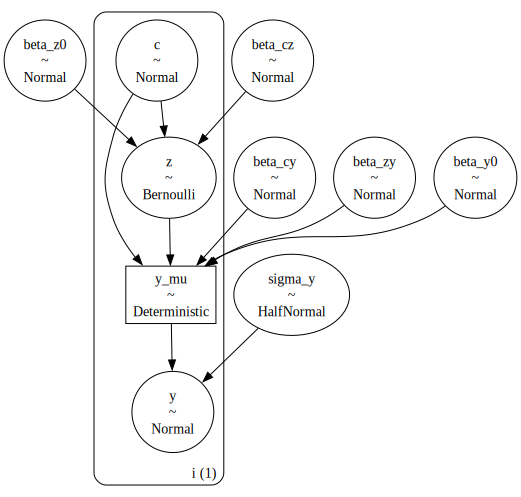

In [9]:
with pm.Model(coords_mutable={"i": [0]}) as model_generative:
    # priors on Y <- C -> Z
    beta_y0 = pm.Normal("beta_y0")
    beta_cy = pm.Normal("beta_cy")
    beta_cz = pm.Normal("beta_cz")
    # priors on Z -> Y causal path
    beta_z0 = pm.Normal("beta_z0")
    beta_zy = pm.Normal("beta_zy")
    # observation noise on Y
    sigma_y = pm.HalfNormal("sigma_y")
    # core nodes and causal relationships
    c = pm.Normal("c", mu=0, sigma=1, dims="i")
    z = pm.Bernoulli("z", p=pm.invlogit(beta_z0 + beta_cz * c), dims="i")
    y_mu = pm.Deterministic("y_mu", beta_y0 + (beta_zy * z) + (beta_cy * c), dims="i")
    y = pm.Normal("y", mu=y_mu, sigma=sigma_y, dims="i")

pm.model_to_graphviz(model_generative)

In [63]:
true_ATE = 0.0

true_values = {
    "beta_z0": 0.0,
    "beta_y0": 0.0,
    "beta_cz": 1.5,
    "beta_zy": true_ATE,
    "beta_cy": 1.0,
    "sigma_y": 0.2,
}

model_simulate = do(model_generative, true_values)

In [64]:
N = 100

with model_simulate:
    simulate = pm.sample_prior_predictive(samples=N, random_seed=rng)

observed = {
    "c": simulate.prior["c"].values.flatten(),
    "y": simulate.prior["y"].values.flatten(),
    "z": simulate.prior["z"].values.flatten(),
}

df = pd.DataFrame(observed).sort_values("c", ascending=False)
df.head()

Sampling: [c, y, z]


c         y  z
8   2.479241  2.607639  1
62  1.754066  1.772028  1
48  1.686662  1.797330  1
71  1.450670  1.519356  1
91  1.319701  1.011073  0

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


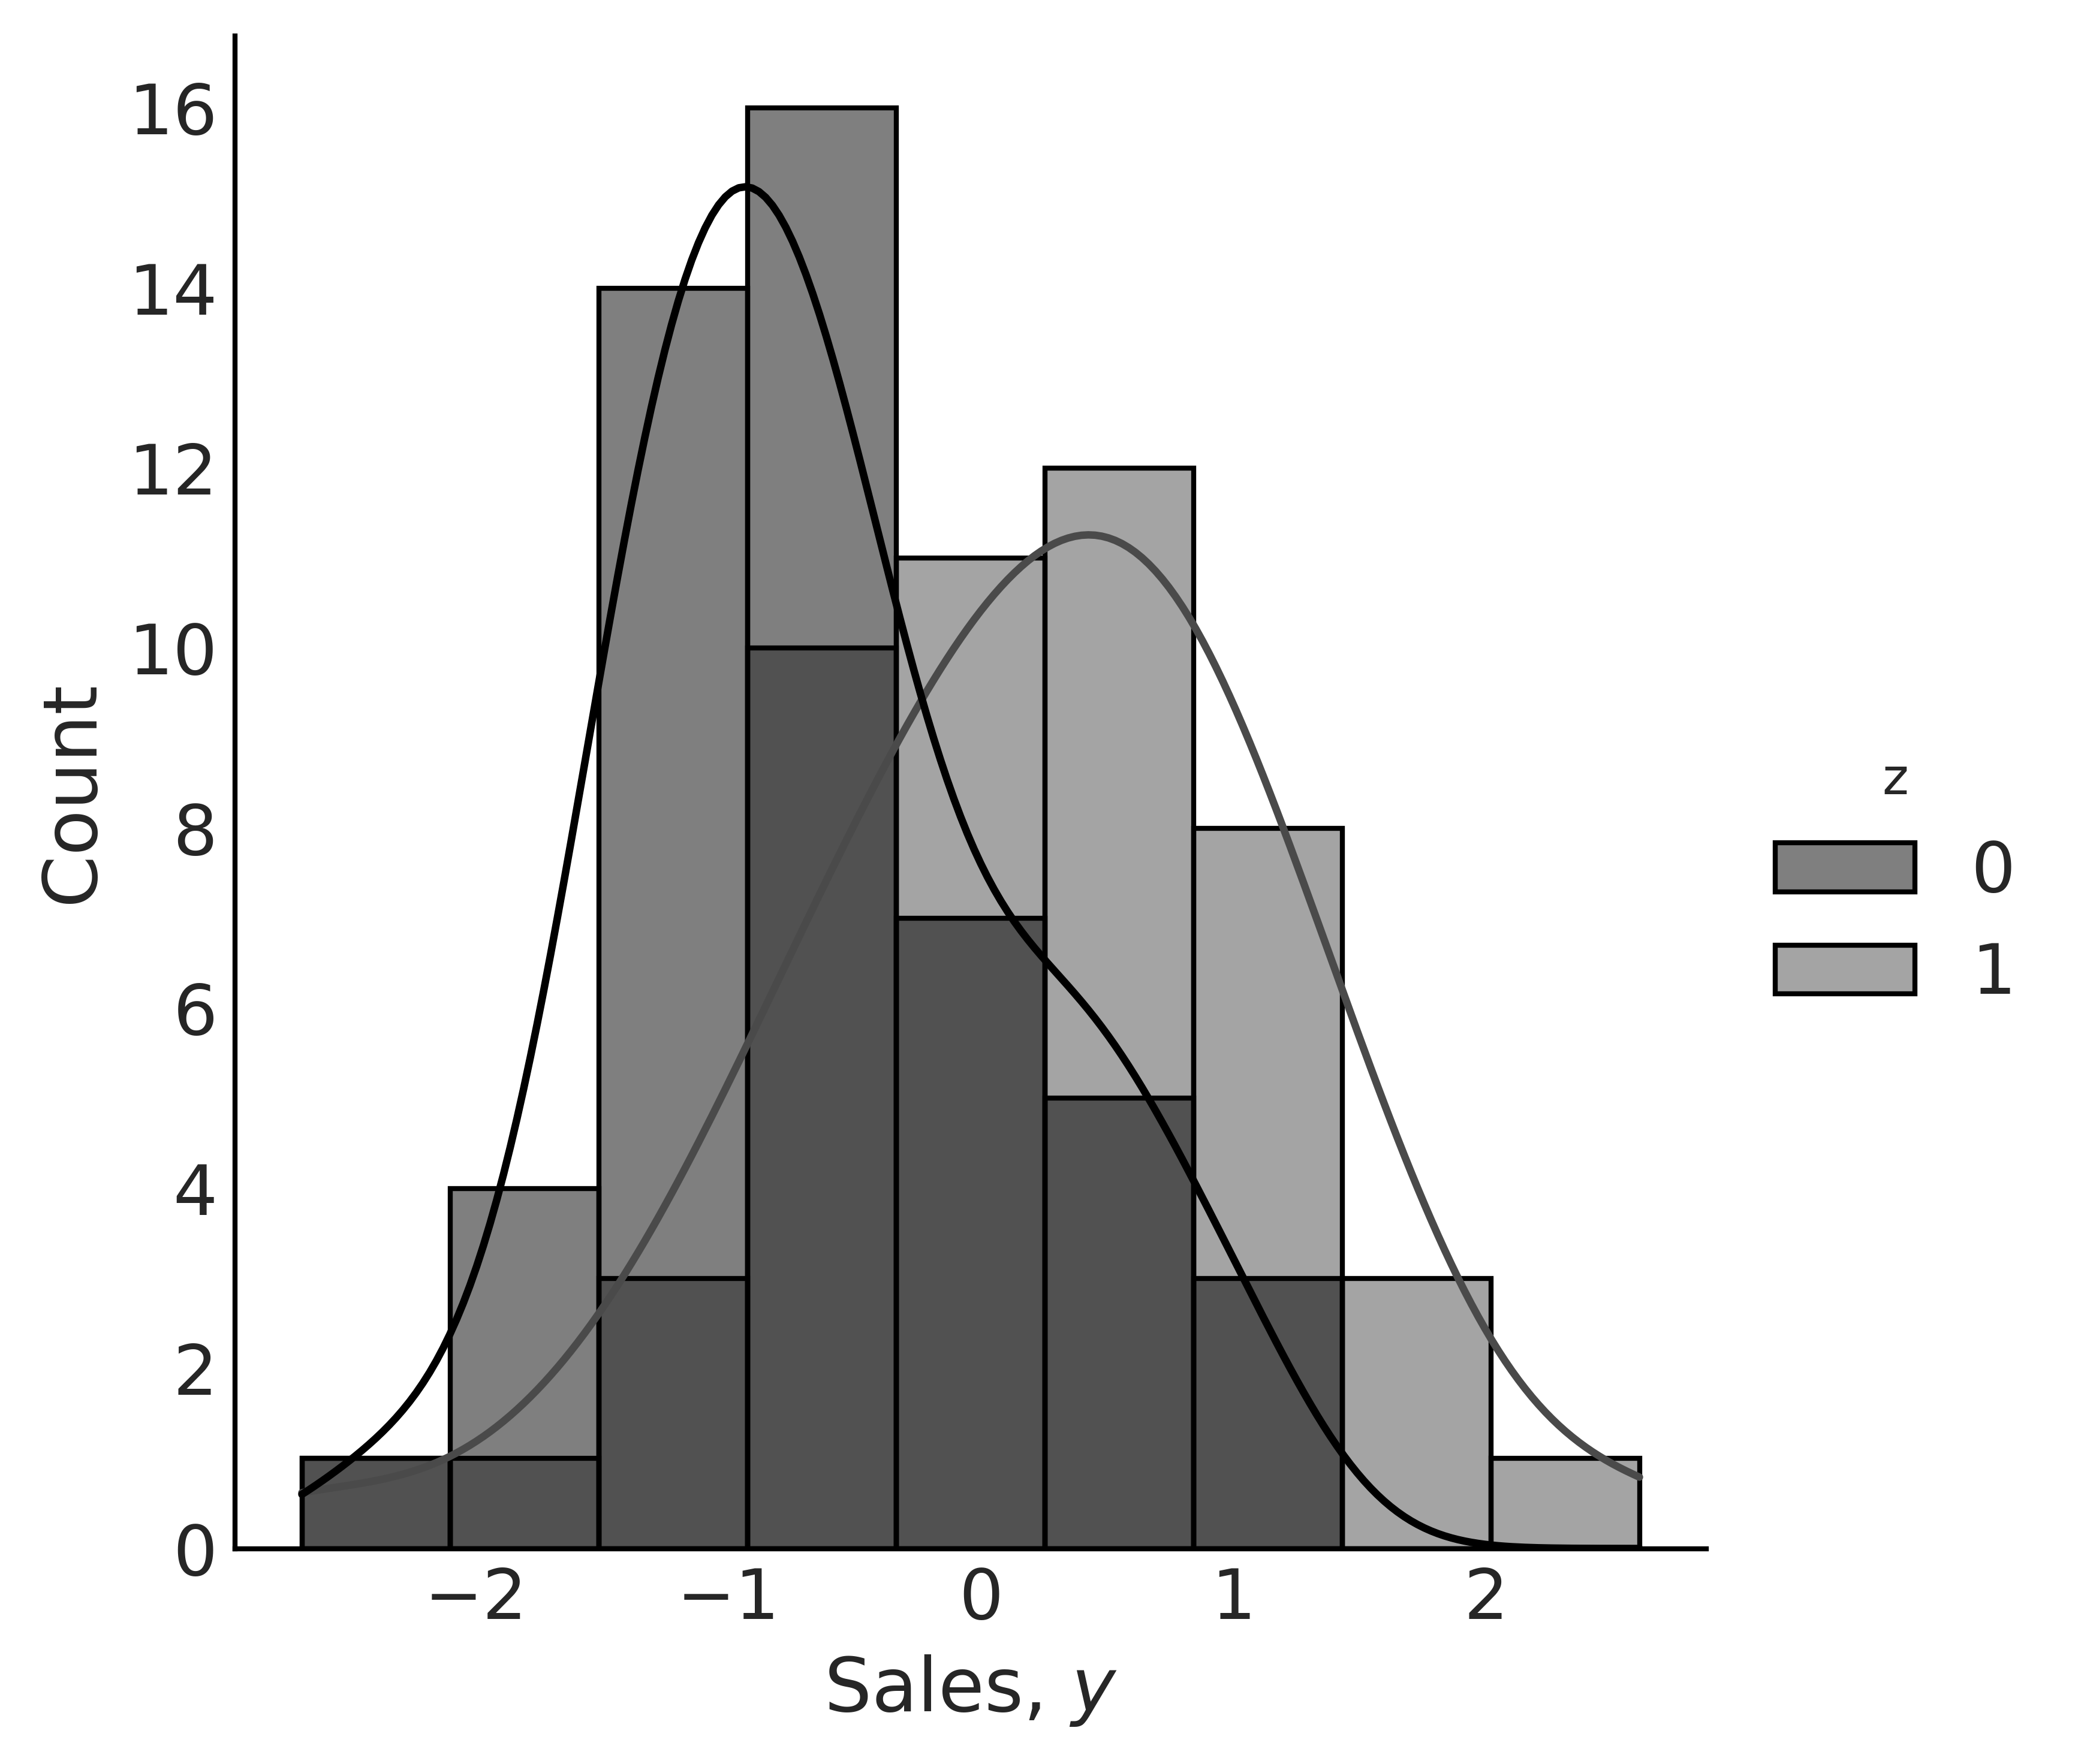

In [65]:
ax = sns.displot(data=df, x="y", hue="z", kde=True)
ax.set(xlabel="Sales, $y$");

In [67]:
model_inference = observe(model_generative, {"c": df["c"], "y": df["y"], "z": df["z"]})
model_inference.set_dim("i", N, coord_values=np.arange(N))

In [69]:
with model_inference:
    idata = pm.sampling_jax.sample_numpyro_nuts(random_seed=rng)

Compiling...
Compilation time =  0:00:01.833976
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]








Running chain 0:   0%|          | 0/2000 [00:04<?, ?it/s]

Running chain 3: 100%|██████████| 2000/2000 [00:04<00:00, 446.75it/s]  


Sampling time =  0:00:04.738733
Transforming variables...
Transformation time =  0:00:00.057325


/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_35134/4104813006.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


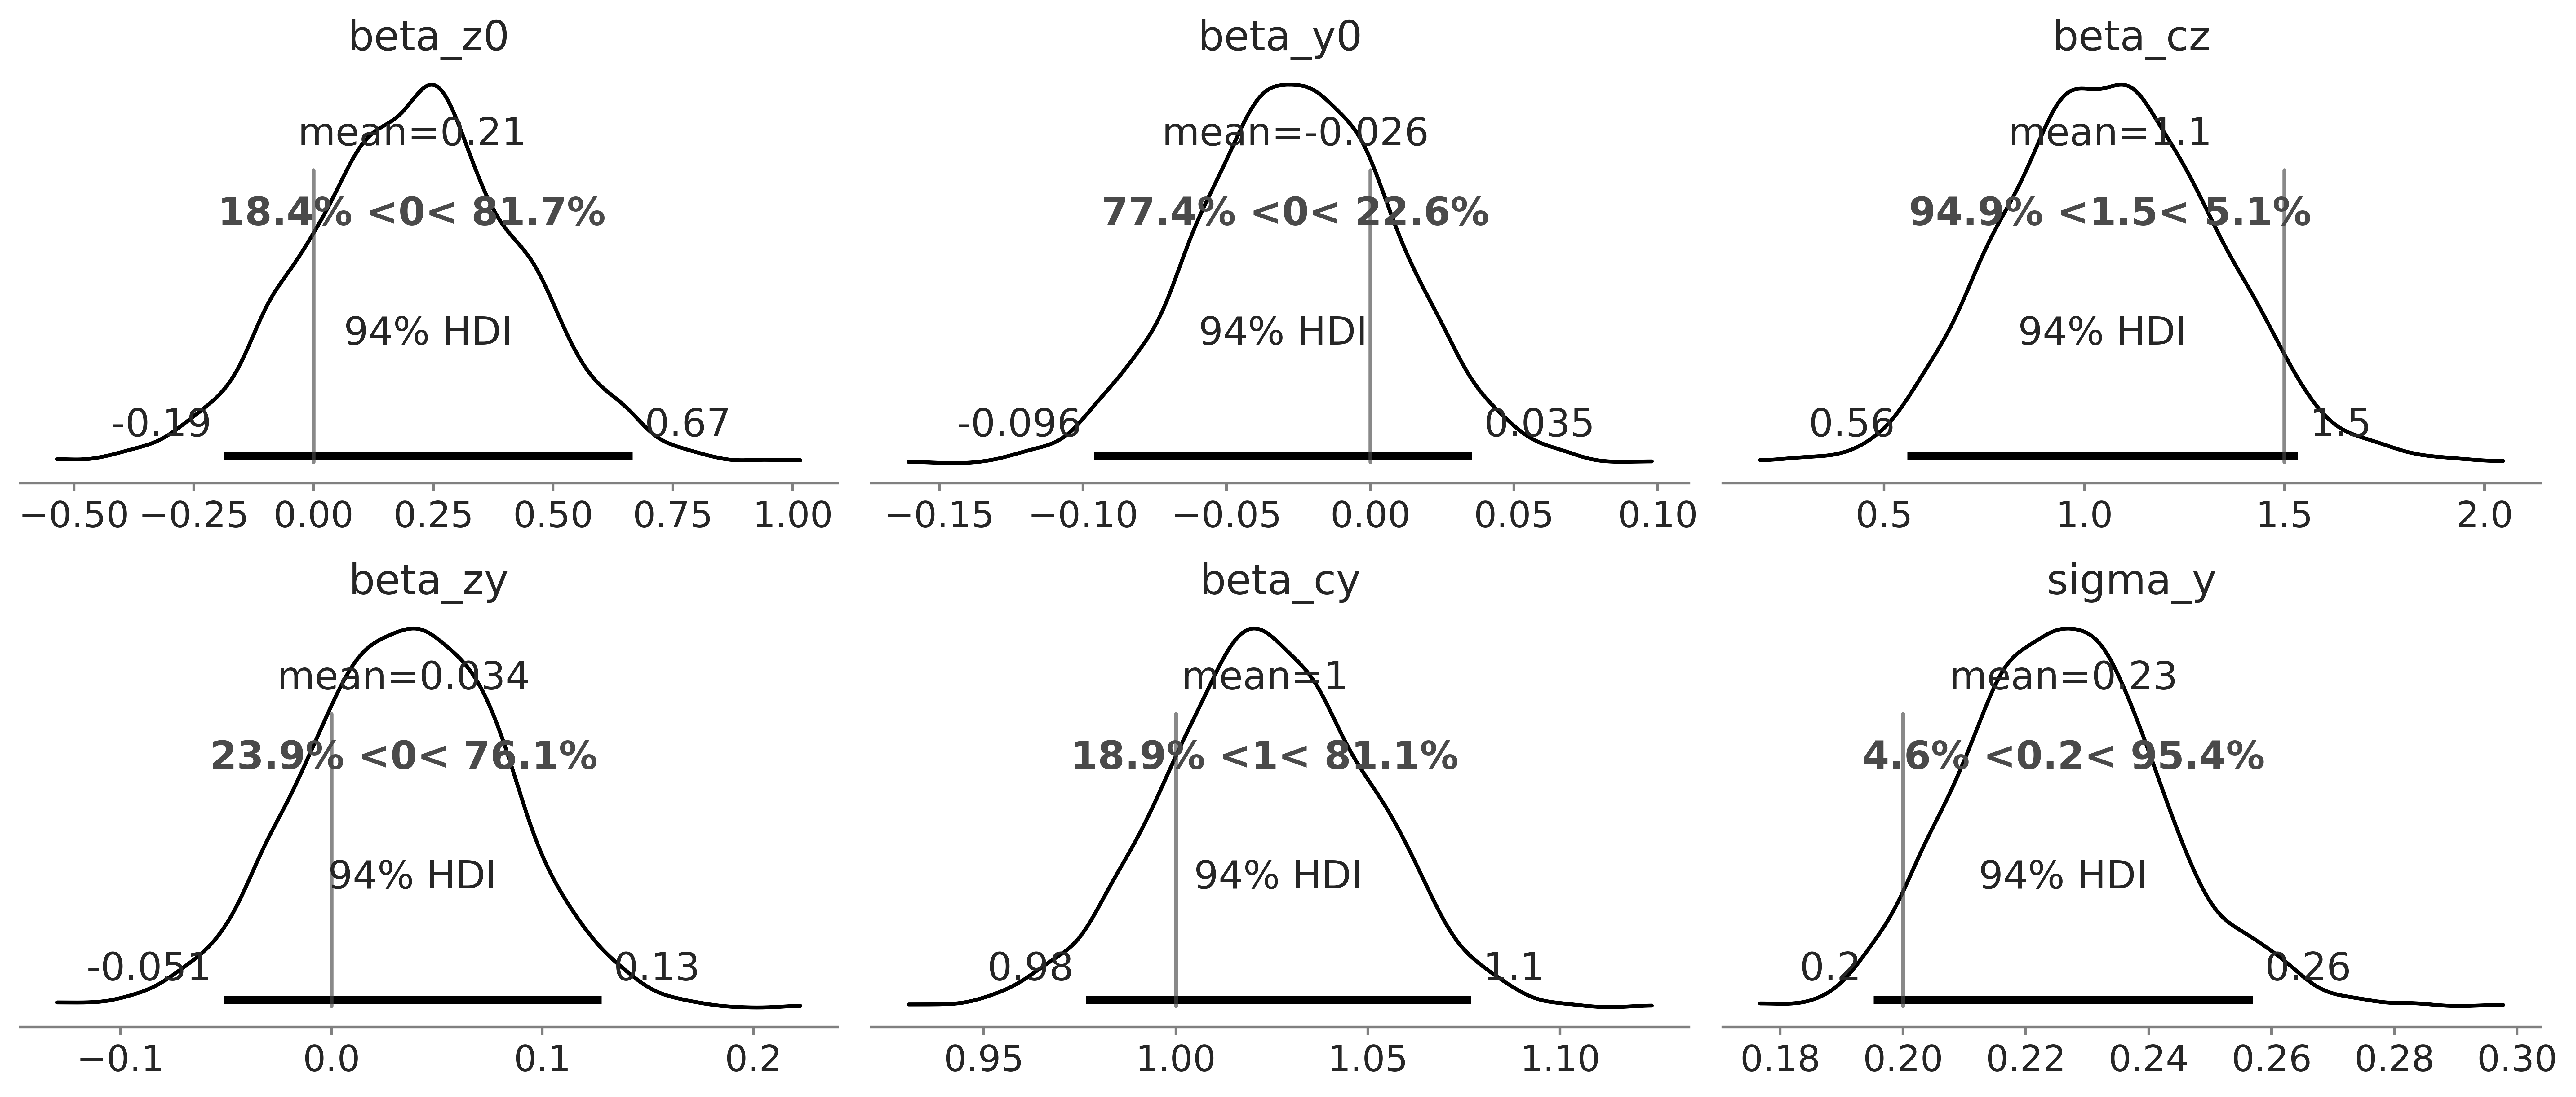

In [70]:
az.plot_posterior(
    idata,
    var_names=list(true_values.keys()),
    ref_val=list(true_values.values()),
    figsize=(14, 6),
)
plt.tight_layout();

In [71]:
# Replace c with its observed values
model_counterfactual = do(model_inference, {"c": df["c"]})

In [72]:
# Generate models with Z=0 and Z=1
model_z0 = do(model_counterfactual, {"z": np.zeros(N, dtype="int32")}, prune_vars=True)
model_z1 = do(model_counterfactual, {"z": np.ones(N, dtype="int32")}, prune_vars=True)

In [73]:
# Sample new sales data assuming Google Ads off: P(Y | c, do(z=0))
idata_z0 = pm.sample_posterior_predictive(
    idata,
    model=model_z0,
    predictions=True,
    var_names=["y_mu"],
    random_seed=rng,
)
# Sample new sales data assuming Google Ads on: P(Y | c, do(z=1))
idata_z1 = pm.sample_posterior_predictive(
    idata,
    model=model_z1,
    predictions=True,
    var_names=["y_mu"],
    random_seed=rng,
)

Sampling: []


Sampling: []


In [74]:
# calculate estimated ATE
ATE_est = idata_z1.predictions - idata_z0.predictions
print(f"Estimated ATE = {ATE_est.y_mu.mean().values:.2f}")

Estimated ATE = 0.03


In [75]:
def plot_causal_estimates(models, ATE_est, model_names):
    """Utility plot function to generate figure for estimated outcomes and causal effects."""
    fig, ax = plt.subplots(1, 2)

    # left plot of estimated outcomes
    ret = az.plot_forest(
        [models[0].predictions, models[1].predictions],
        combined=True,
        ax=ax[0],
        model_names=model_names,
    )
    # remove alternate row shading
    for p in ret[0].patches:
        p.set_color("white")

    # right plot of estimated ATE
    az.plot_posterior(
        idata, var_names="beta_zy", ref_val=true_ATE, round_to=4, ax=ax[1]
    )

    # formatting
    ax[0].set(
        title="Estimated outcomes under intervention",
        ylabel="unit, $i$ (ordered)",
        yticklabels=[],
    )
    ax[1].set(title="Average Treatment Effect")
    plt.tight_layout()

    plt.suptitle(
        "Unit level estimates with do operation,\nand estimate of Average Treatment Effect",
        y=1.05,
    );

/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_35134/3505337537.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


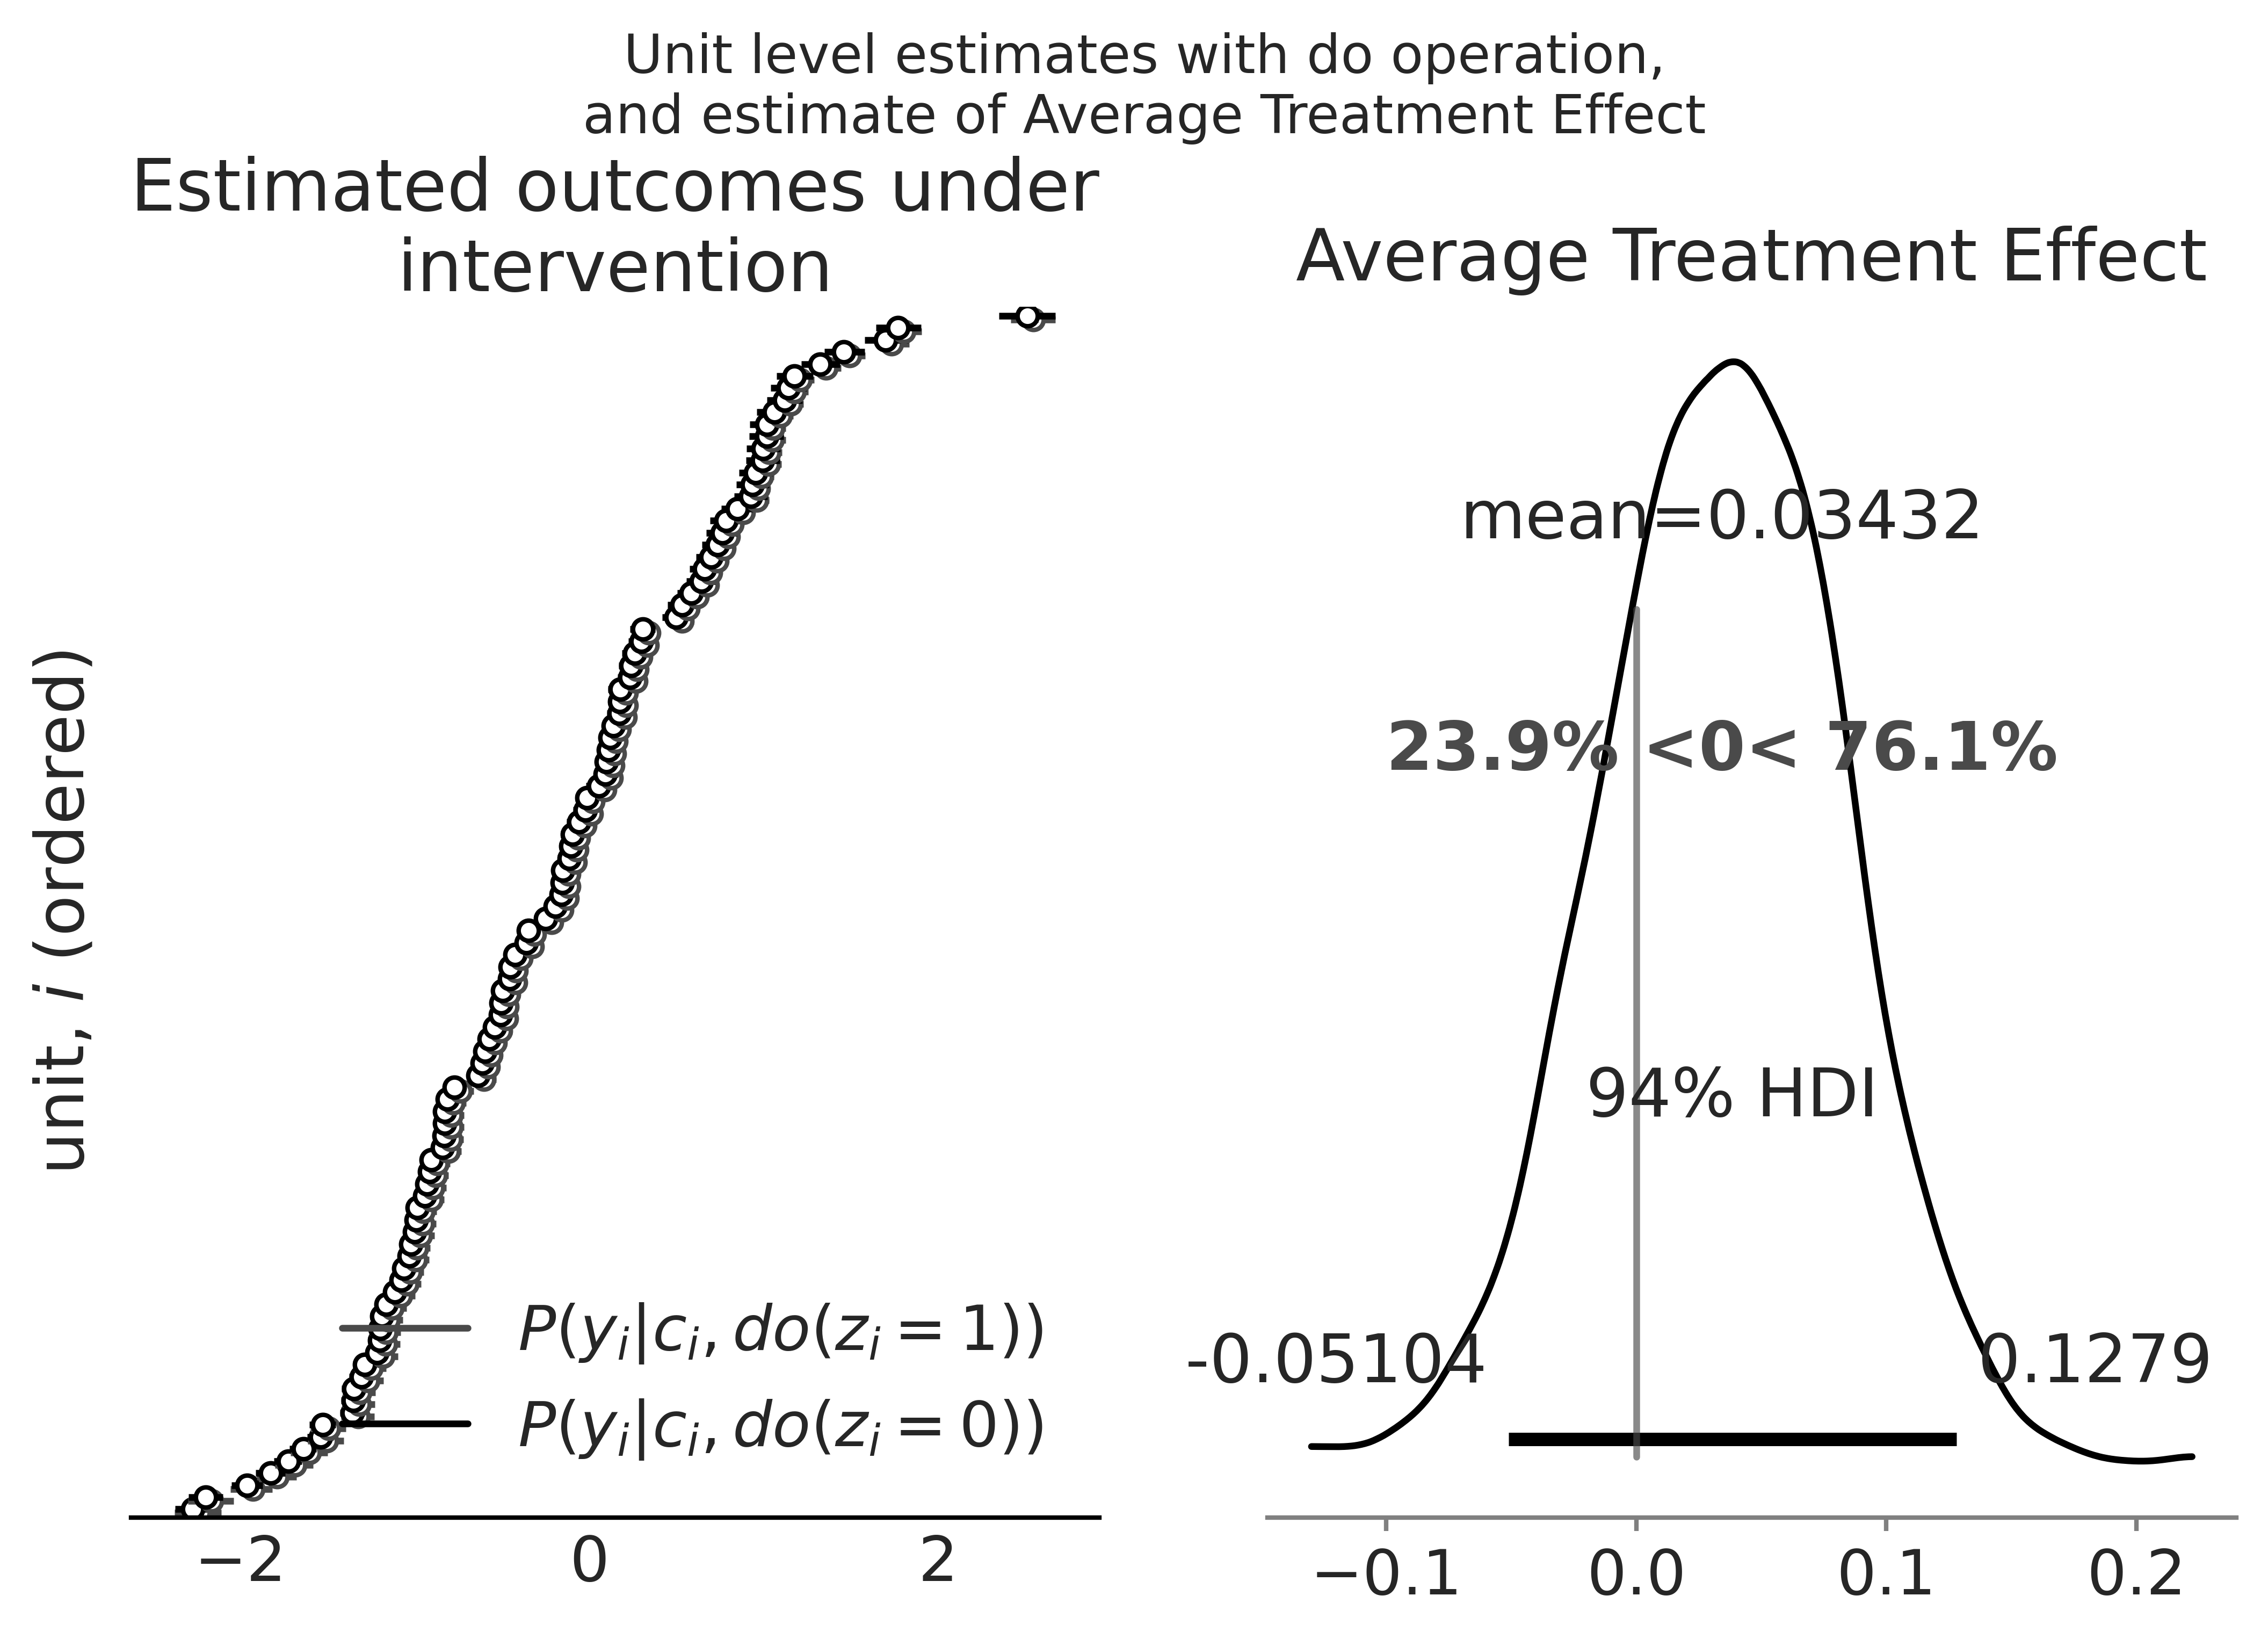

In [76]:
plot_causal_estimates(
    [idata_z0, idata_z1],
    ATE_est,
    model_names=[r"$P(y_i|c_i,do(z_i=0))$", r"$P(y_i|c_i,do(z_i=1))$"],
)

In [62]:
percent = (idata.posterior["beta_zy"] / idata.posterior["beta_cy"]) * 100
print(
    f"Causal effect of Google Ads on sales is {percent.mean():.1f}% [{az.hdi(percent).x.data[0]:.1f}%,{az.hdi(percent).x.data[1]:.1f}%] of the effect of TV on sales"
)

Causal effect of Google Ads on sales is 98.8% [86.9%,110.7%] of the effect of TV on sales


In [77]:
size = 100  # numero di osservazioni nel campione
true_intercept = 1  # alpha
true_slope = 2  # beta

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)  # sigma = 0.5

data = pd.DataFrame(dict(x=x, y=y))
data.head()

x         y
0  0.000000  1.388896
1  0.010101  1.053217
2  0.020202  1.604025
3  0.030303  1.294361
4  0.040404  0.651162

In [87]:
with pm.Model(coords_mutable={"i": [0]}) as model_generative:
    # priors on Y <- X
    beta_y0 = pm.Normal("beta_y0")
    beta_xy = pm.Normal("beta_xy")
    
    # observation noise on Y
    sigma_y = pm.HalfNormal("sigma_y")
    
    # core node and causal relationship
    x = pm.Normal("x", mu=0, sigma=1, dims="i")
    y_mu = pm.Deterministic("y_mu", beta_y0 + (beta_xy * x), dims="i")
    y = pm.Normal("y", mu=y_mu, sigma=sigma_y, dims="i")

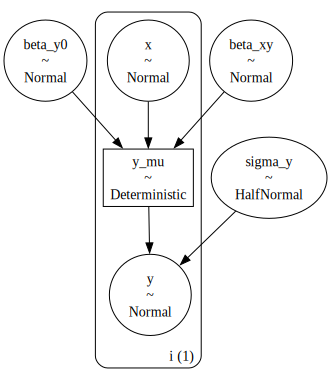

In [88]:
pm.model_to_graphviz(model_generative)

In [116]:
true_values = {
    "beta_y0": 0.25,
    "beta_xy": 1.0,
    "sigma_y": 0.75
}

model_simulate = do(model_generative, true_values)

In [117]:
N = 100

with model_simulate:
    simulate = pm.sample_prior_predictive(samples=N, random_seed=rng)

observed = {
    "x": simulate.prior["x"].values.flatten(),
    "y": simulate.prior["y"].values.flatten()
}

df = pd.DataFrame(observed)
df.head()

Sampling: [x, y]


x         y
0 -0.022429  0.598942
1  0.310279 -0.064133
2  0.391501  0.160383
3  0.843138  0.510674
4  0.728964  0.504657

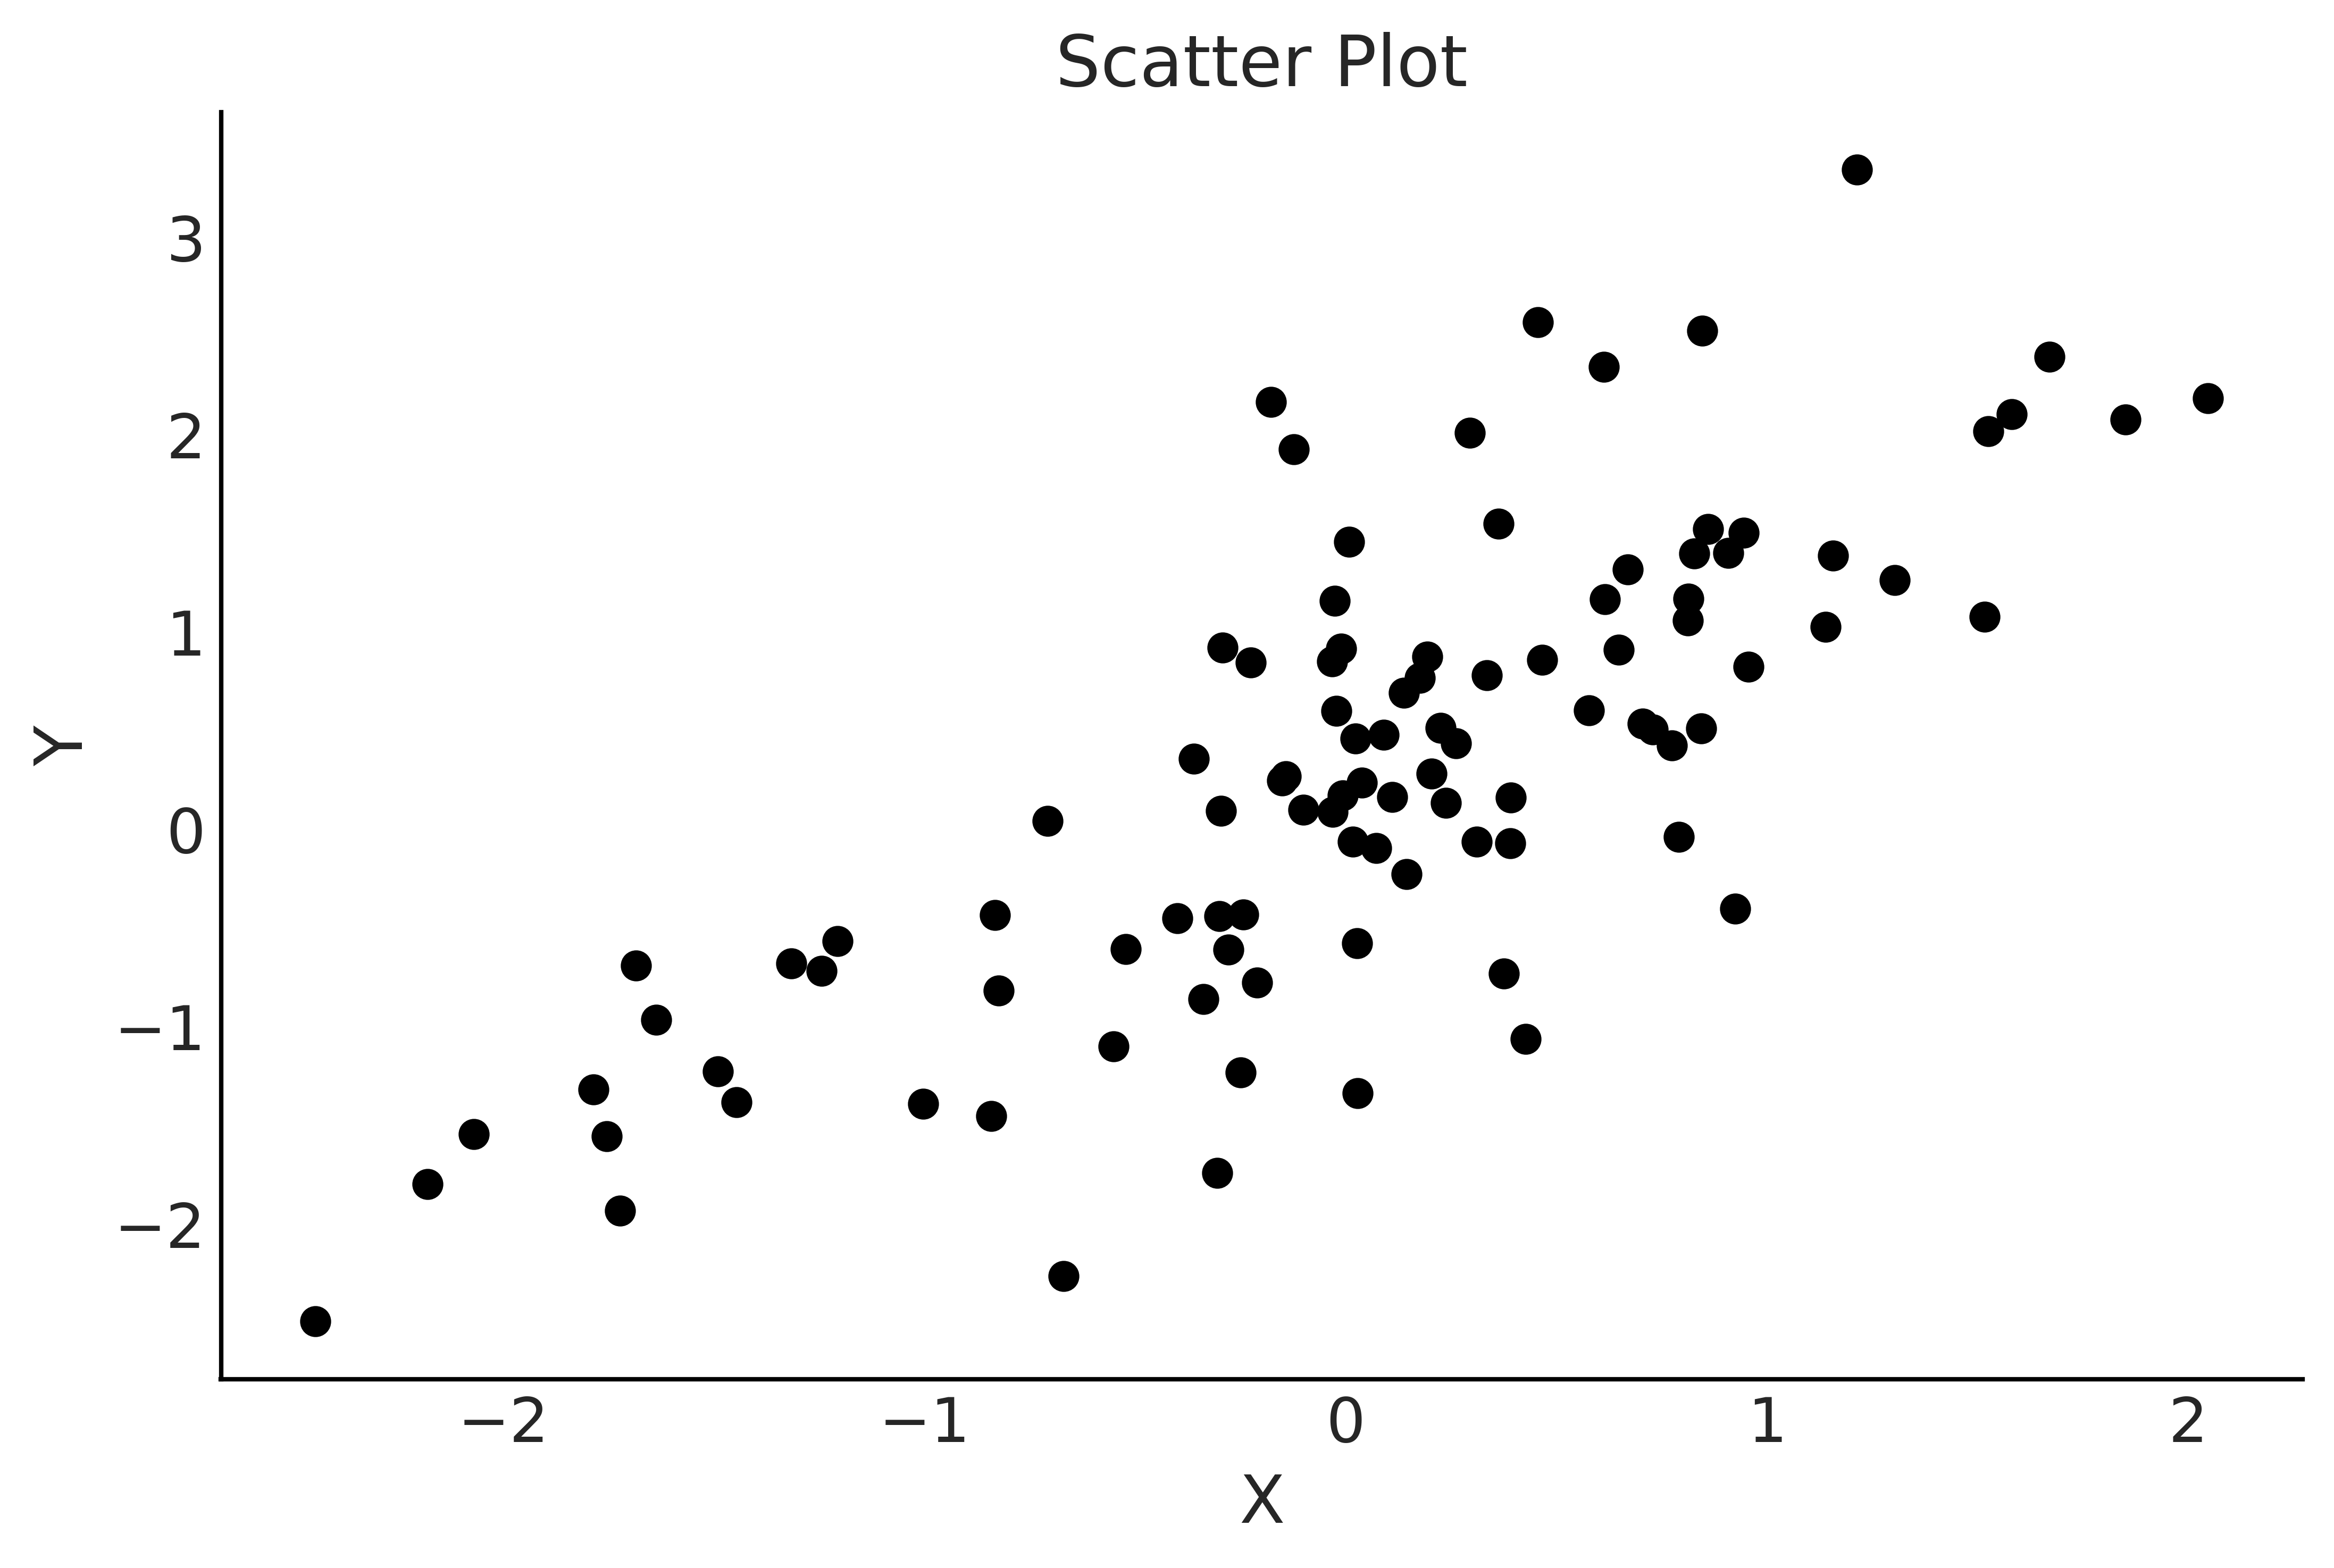

In [119]:
# Creating a scatter plot
plt.scatter(df.x, df.y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot")
plt.show()

In [120]:
model_inference = observe(model_generative, {"x": df["x"], "y": df["y"]})
model_inference.set_dim("i", N, coord_values=np.arange(N))

In [122]:
with model_inference:
    idata = pm.sampling_jax.sample_numpyro_nuts(random_seed=rng)

Compiling...
Compilation time =  0:00:01.007001
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]







Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 634.26it/s]


Sampling time =  0:00:03.331153
Transforming variables...
Transformation time =  0:00:00.068479


/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_35134/2225061524.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


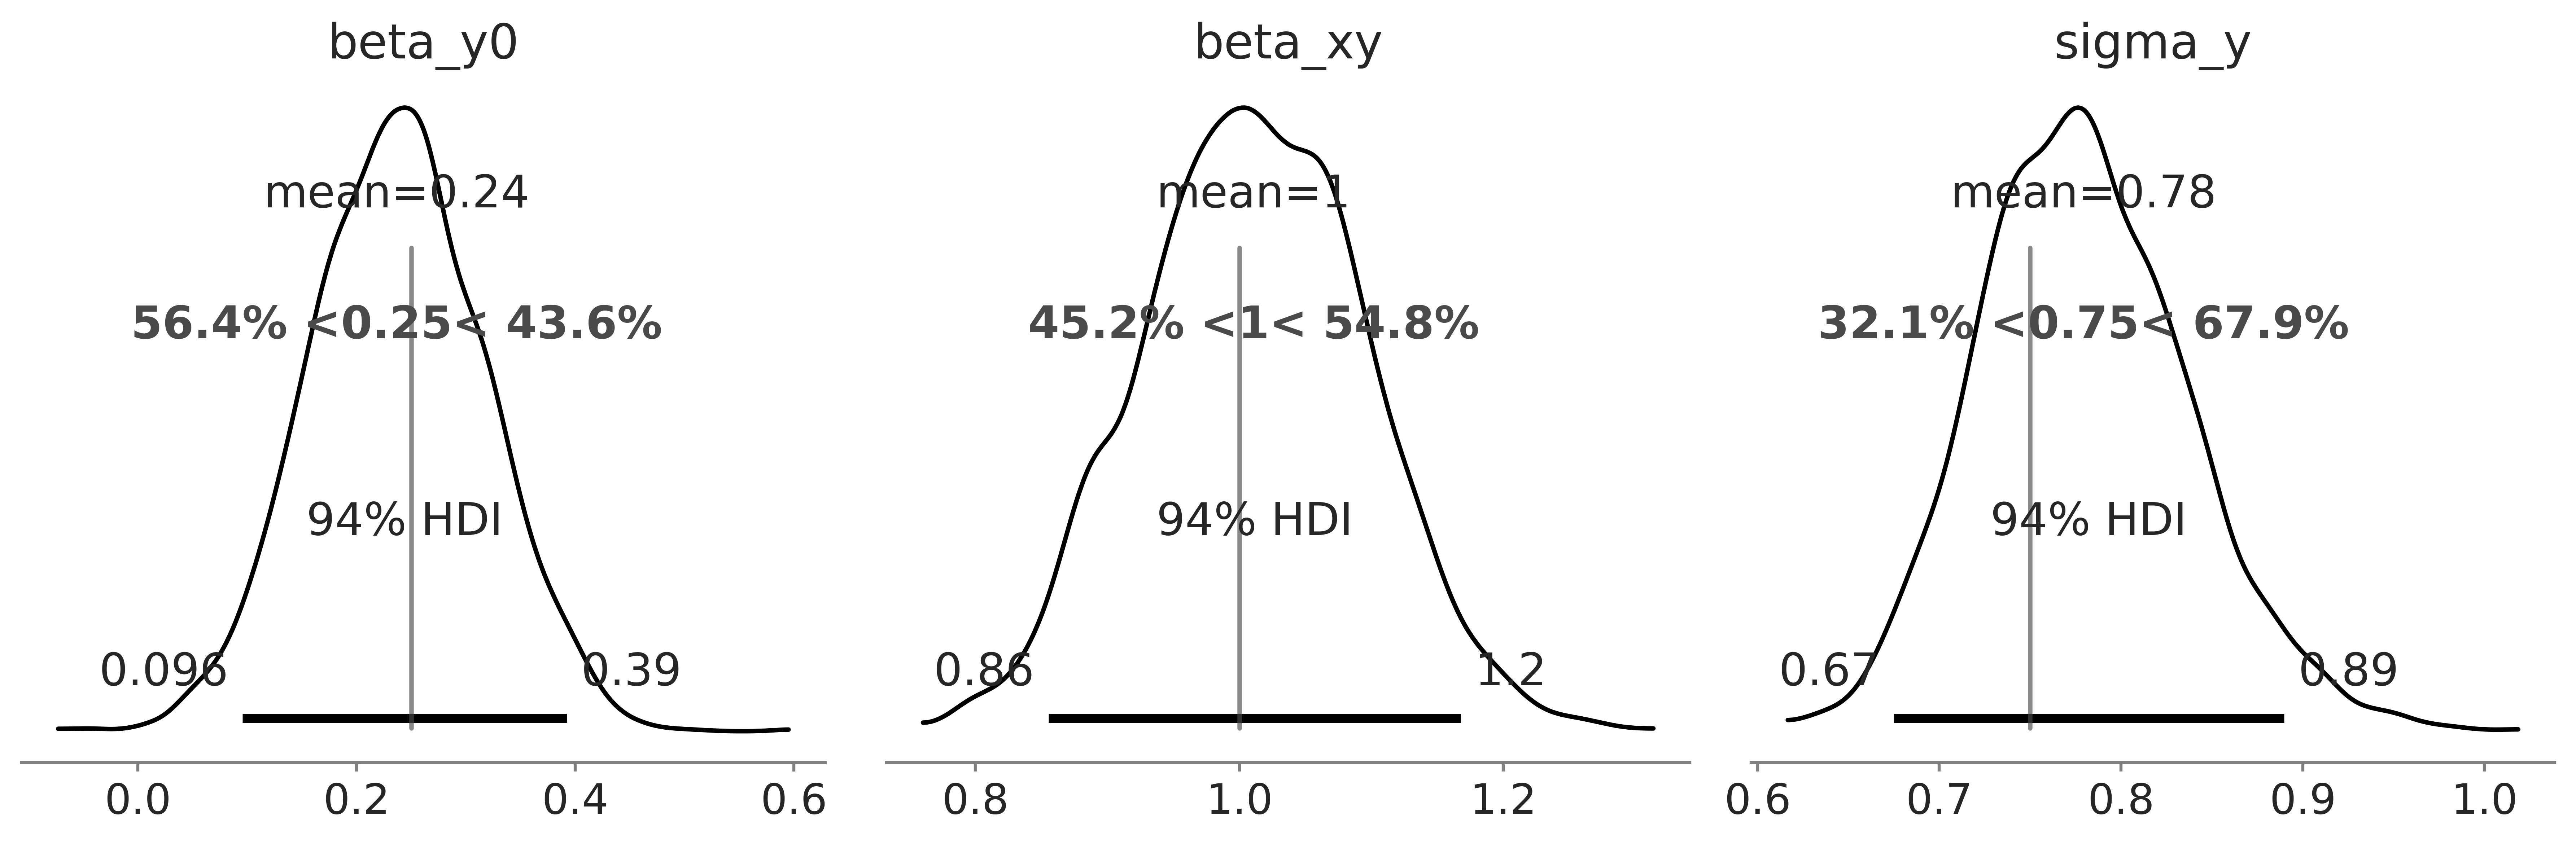

In [123]:
az.plot_posterior(
    idata,
    var_names=list(true_values.keys()),
    ref_val=list(true_values.values()),
    figsize=(12, 4),
)
plt.tight_layout();

In [19]:
N = 50

with pm.Model() as model_generative:
    # priors on Y <- X
    beta_y0 = pm.Normal("beta_y0")
    beta_xy = pm.Normal("beta_xy")
    
    # observation noise on Y
    sigma_y = pm.HalfNormal("sigma_y")
    
    # core node and causal relationship
    N = 100  # Make sure you define N based on your actual data
    x = pm.Normal("x", mu=0, sigma=1, shape=N)
    y_mu = pm.Deterministic("y_mu", beta_y0 + (beta_xy * x))
    y = pm.Normal("y", mu=y_mu, sigma=sigma_y, shape=N)

In [20]:
true_values = {
    "beta_y0": 0.25,
    "beta_xy": 1.0,
    "sigma_y": 0.75
}

model_simulate = do(model_generative, true_values)

In [23]:
with model_simulate:
    simulate = pm.sample_prior_predictive(samples=N, random_seed=rng)

observed = {
    "y": simulate.prior["y"].values.flatten(),
    "x": simulate.prior["x"].values.flatten(),
}

df = pd.DataFrame(observed).sort_values("x", ascending=False)
df.shape

Sampling: [x, y]


(10000, 2)

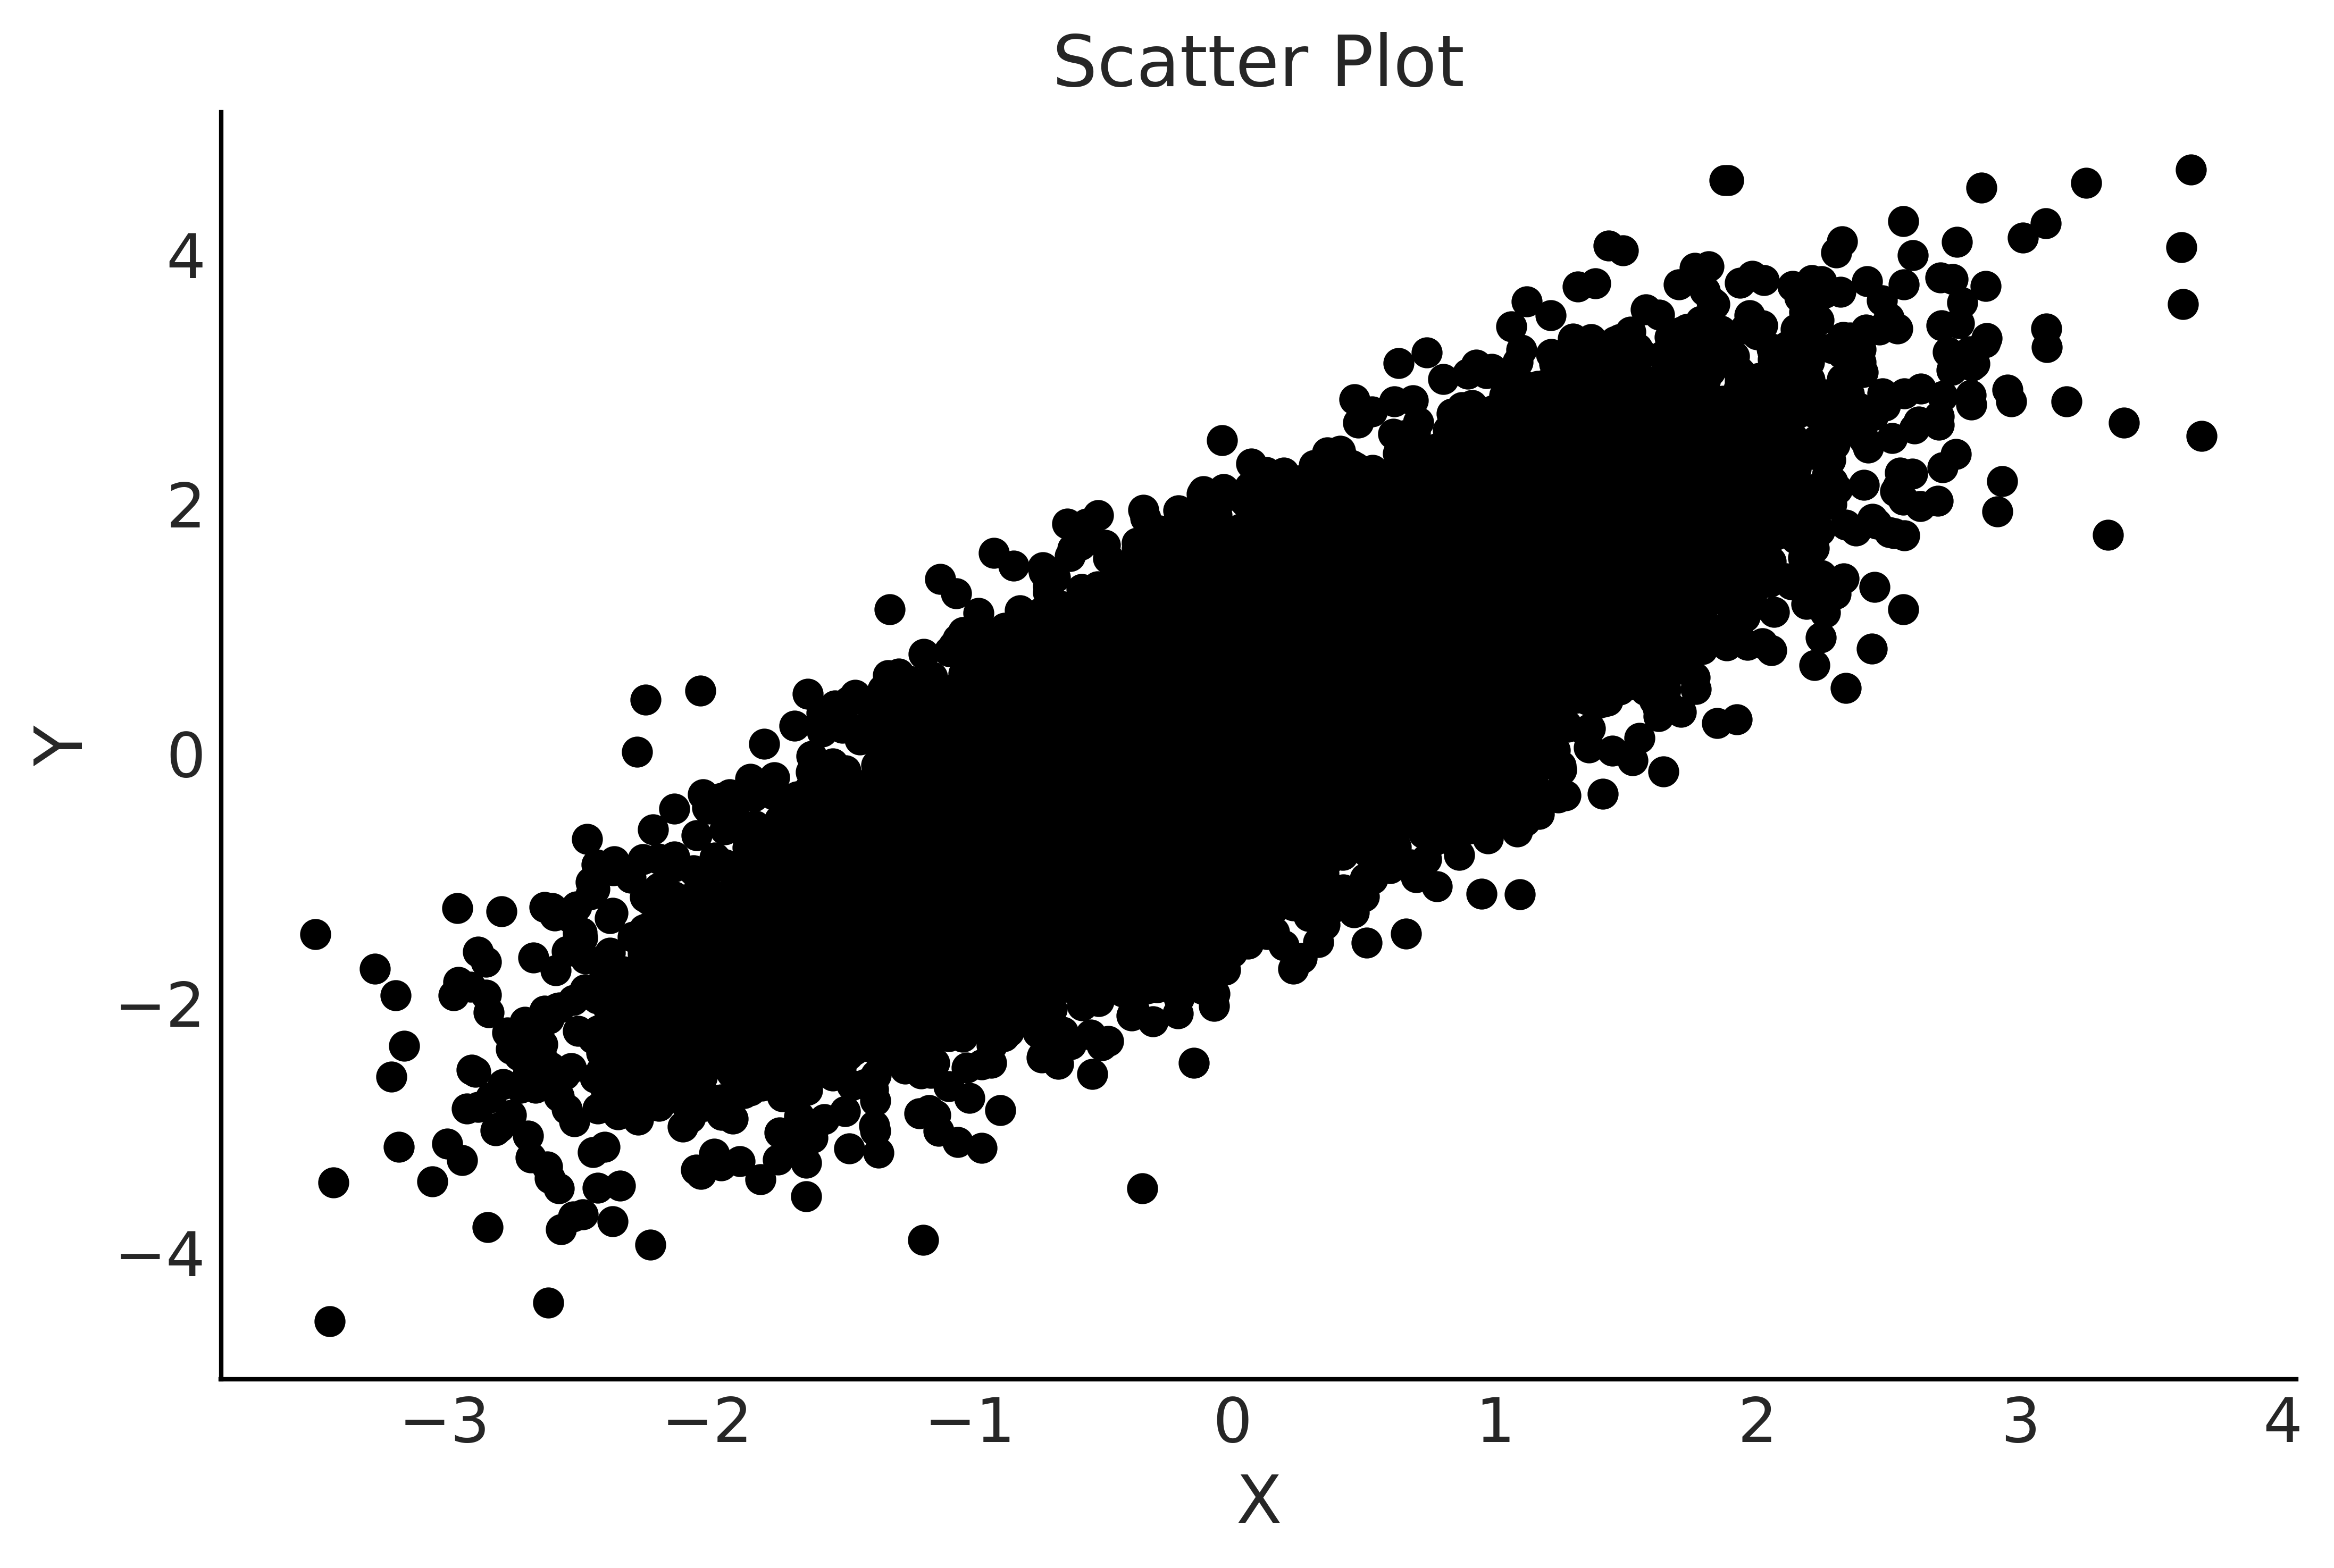

In [22]:
# Creating a scatter plot
plt.scatter(df.x, df.y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot")
plt.show()

In [3]:
model_inference = observe(model_generative, {"x": df["x"], "y": df["y"]})

NameError: name 'observe' is not defined

In [141]:
with model_inference:
    idata = pm.sampling_jax.sample_numpyro_nuts(random_seed=rng)

Compiling...
Compilation time =  0:00:01.085641
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]







Running chain 3: 100%|██████████| 2000/2000 [00:04<00:00, 433.79it/s]

Sampling time =  0:00:04.775336
Transforming variables...
Transformation time =  0:00:00.020804


/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_35134/2225061524.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


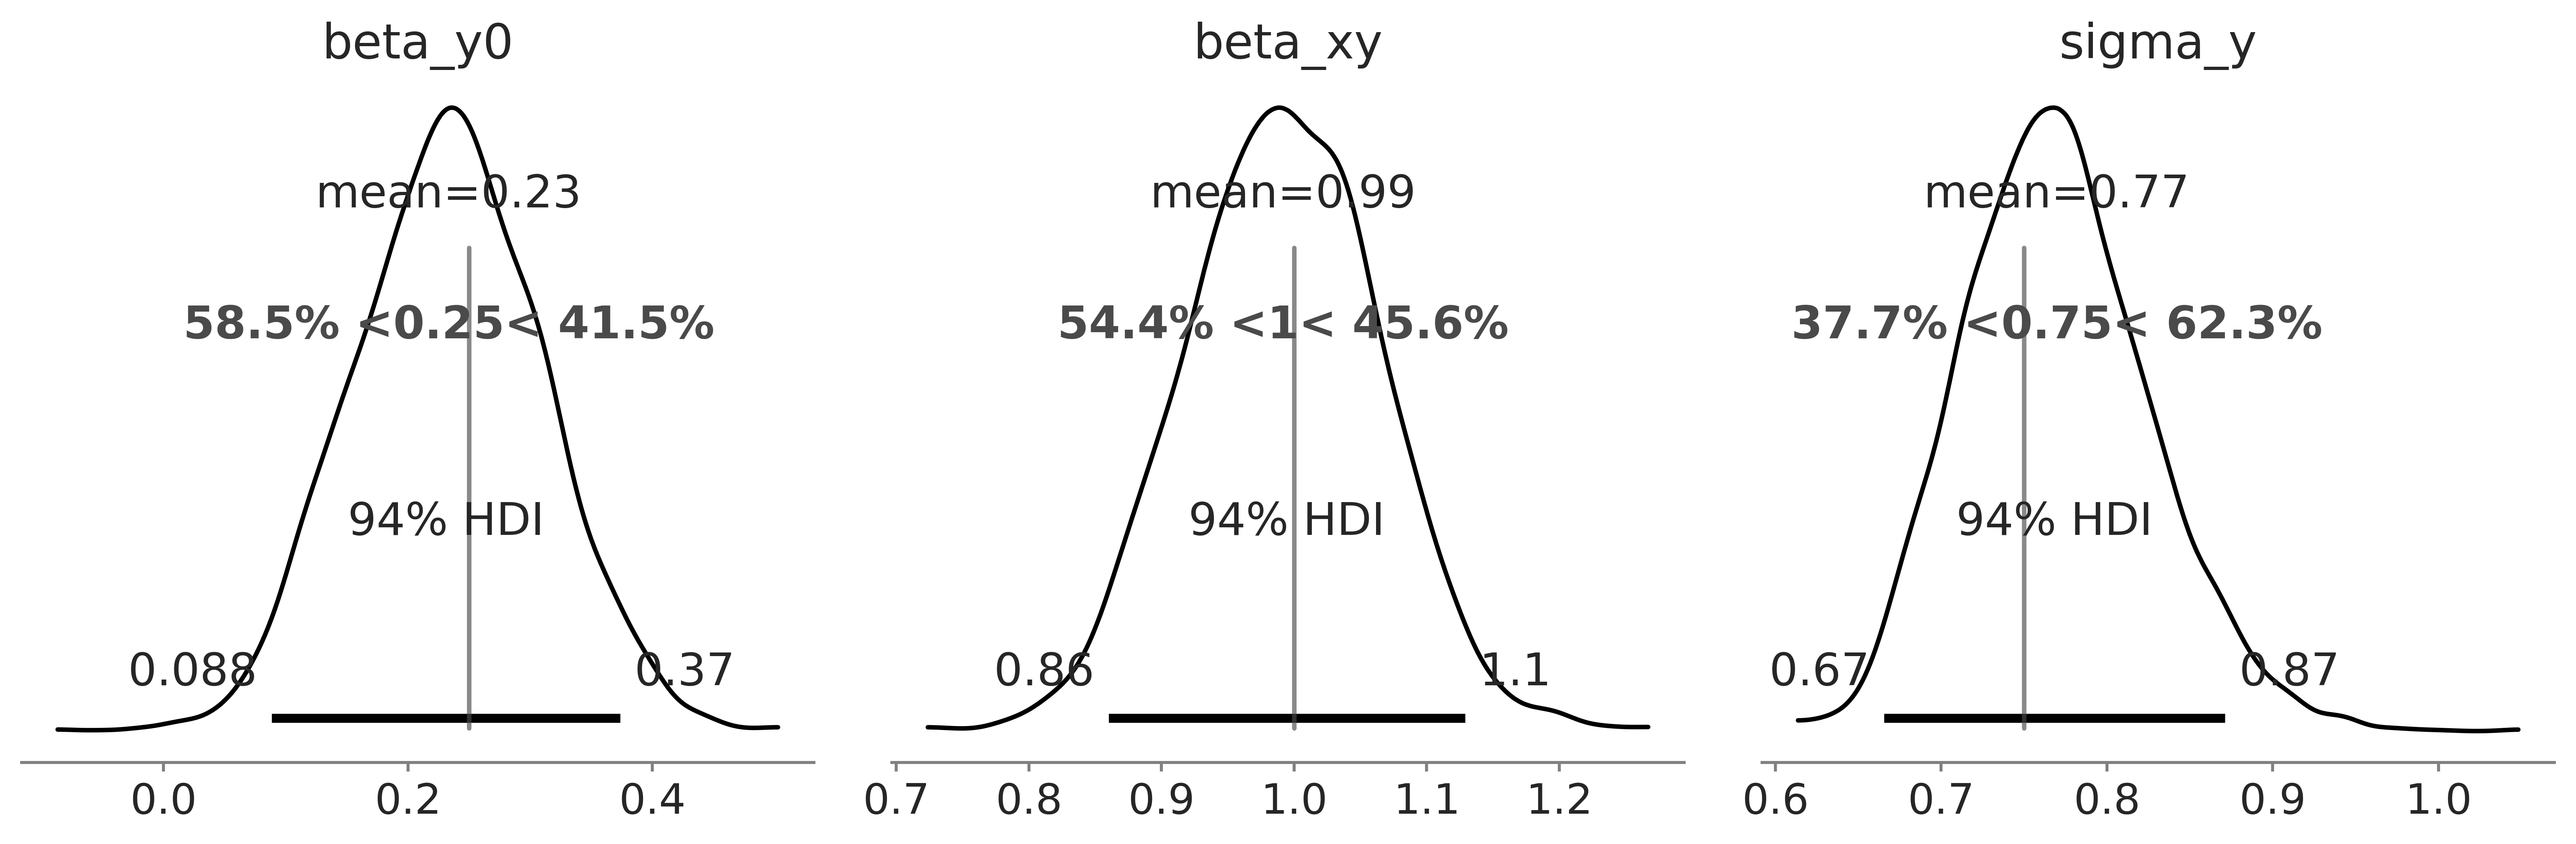

In [142]:
az.plot_posterior(
    idata,
    var_names=list(true_values.keys()),
    ref_val=list(true_values.values()),
    figsize=(12, 4),
)
plt.tight_layout();